In [1]:
# !pip install pytorch_lightning > /dev/null
# !pip install omegaconf > /dev/null
# !pip install einops > /dev/null
# !pip install torchmetrics > /dev/null
# !pip install wandb > /dev/null
# !pip install lightning-bolts > /dev/null
# !pip install albumentations > /dev/null
# !pip install timm > /dev/null

In [2]:
import os
import json
import glob
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import albumentations as A
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import KFold

/usr/local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def show_image(image, figsize=(5, 5), cmap=None, title='', xlabel=None, ylabel=None, axis=False):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis(axis)
    plt.show();
    
def show_image_mask(image, mask, name='', figsize=(10, 15), axis=False):
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image {name}")
    plt.axis(axis)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask {name}")
    plt.axis(axis)
    
    plt.show();
    
def show_predict(image, gt_mask, pr_mask, name='', figsize=(15, 25), axis=False):
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"image {name}")
    plt.axis(axis)

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask)
    plt.title(f"gt_mask {name}")
    plt.axis(axis)
    
    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask)
    plt.title(f"pr_mask {name}")
    plt.axis(axis)
    
    plt.show();
    
def get_image_mask_by_path(img_name, img_folder, msk_folder):
    img_path = os.path.join(img_folder, img_name)
    msk_path = os.path.join(msk_folder, img_name)
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(msk_path)
    
    return image, mask
    
def get_img_names(folder, img_format='png'):
    img_paths = glob.glob(os.path.join(folder, f'*.{img_format}'))
    img_names = [os.path.basename(x) for x in img_paths]
    return img_names

In [4]:
GLOBAL_CONFIG = {
    'gpus': [0],
    'seed': 17,
    
    'folds_count': 3,
    
    'IMG_H': 512,
    'IMG_W': 512*2,
    
    'bs': 16,
    'epoch': 128,
    'num_workers': 16,
    
    'start_lr': 0.001,
    'max_lr': 0.002,
    
    'wandb': False,
    'exp_name': 'unetplus_resnet34',
}


seed_everything(GLOBAL_CONFIG['seed'])
if GLOBAL_CONFIG['wandb'] :
    import wandb
    wandb.login()
    wandb.config = GLOBAL_CONFIG

In [5]:
TRAIN_FOLDER = # set path to train folder

TRAIN_IMAGES_FOLDER = f'{TRAIN_FOLDER}/images'
TRAIN_MASKS_FOLDER = f'{TRAIN_FOLDER}/mask'

TRAIN_IMG_NAMES = get_img_names(TRAIN_IMAGES_FOLDER)
LABELS = [0, 6, 7, 10]

LABEL2NAME = {
    0: 'bg',
    6: 'side_rails',
    7: 'main_rails',
    10: 'trains',
}
NAME2LABEL = {v:k for k,v in LABEL2NAME.items()}

LABEL2CLASS = {
    0: 0,
    6: 1,
    7: 2,
    10: 3,
}
CLASS2LABEL = {v:k for k,v in LABEL2CLASS.items()}

len(get_img_names(TRAIN_IMAGES_FOLDER)), len(get_img_names(TRAIN_MASKS_FOLDER))

(8203, 8203)

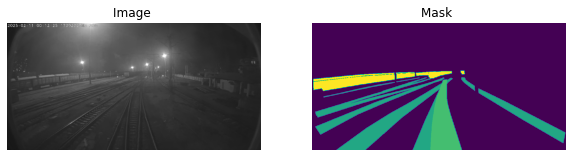

In [6]:
def preprocess_image(image):
    input_img = image.copy()
    img = cv2.resize(input_img, (GLOBAL_CONFIG['IMG_W'], GLOBAL_CONFIG['IMG_H']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1)
    return img
    
def preprocess_multy_mask(image):
    input_img = image.copy()
    img = cv2.resize(input_img, (GLOBAL_CONFIG['IMG_W'], GLOBAL_CONFIG['IMG_H']), interpolation=cv2.INTER_NEAREST)
    img = np.array([(img == x) for x in LABELS[0:]])
    img = np.stack(img, axis=-1).astype(np.float32)
    img = torch.from_numpy(img).permute(2, 0, 1)
    return img

def preprocess_mask(image):
    input_img = image.copy()
    img = cv2.resize(input_img, (GLOBAL_CONFIG['IMG_W'], GLOBAL_CONFIG['IMG_H']), interpolation=cv2.INTER_NEAREST)
    for old_c, new_c in LABEL2CLASS.items():
        img[img == old_c] = new_c
    img = torch.from_numpy(img)
    return img

def process_img2np(image):
    img = image.cpu().clone()
    img = img.permute(1, 2, 0).numpy() * 255
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def process_multimask2np(image):
    img = image.cpu().clone()
    img = img.permute(1, 2, 0).numpy().astype(bool)
    h, w, c = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    for c_index in range(c):
        mask[img[:, :, c_index]] = LABELS[c_index]
    
    return mask

def process_mask2np(image):
    img = image.cpu().clone()
    img = img.numpy() 
    return img

class TrainDataset(Dataset):
    def __init__(self, images_names, images_folder, masks_folder, augmentations=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.images_names = images_names
        self.augmentations = augmentations

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, index):
        img_name = self.images_names[index]
        img_path = os.path.join(self.images_folder, img_name)
        msk_path = os.path.join(self.masks_folder, img_name)
        
        image = cv2.imread(img_path)
        original_mask = cv2.imread(msk_path, 0)
        mask = original_mask.copy()
        
        if self.augmentations is not None:
            item = self.augmentations(image=image, mask=mask)
            image = item['image']
            mask = item['mask']
        
        image = preprocess_image(image)
        multy_mask = preprocess_multy_mask(mask)
        single_mask = preprocess_mask(mask)
        
        return {
            'image': image, 
            'single_mask': single_mask, 
            'multy_mask': multy_mask,
        }

    
def get_train_augs():
    return A.Compose([
            A.OneOf([
                A.RandomCrop(512*1, 512*1, p=1),
                A.RandomCrop(512*1, 512*2, p=1),], p=0.5),
            A.ToGray(p=0.15),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.15),
            A.Rotate(limit=180, border_mode=3, p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.OneOf([A.CoarseDropout(max_holes=i, max_height=i*10, max_width=i*10, p=1) for i in range(5, 10)], p=0.75),
        ], p=1.0)


train_dataset = TrainDataset(TRAIN_IMG_NAMES, TRAIN_IMAGES_FOLDER, TRAIN_MASKS_FOLDER)
item = train_dataset[8]

img = process_img2np(item['image'])
msk = process_multimask2np(item['multy_mask'])

show_image_mask(img, msk*10, figsize=(10, 15))

In [7]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
#         self.model=smp.Unet(encoder_name='resnet34', classes=len(LABELS))
        self.model=smp.UnetPlusPlus(encoder_name='resnet34', classes=len(LABELS))
  
        self.criterions = {
            'fo': smp.losses.FocalLoss(mode='multiclass'),
            'ja': smp.losses.JaccardLoss(mode='multiclass'),
        }
        
        self.crit_weights = {
            'fo': 0.5,
            'ja': 0.5,
        }
        
        self.crit_type = { 
            'fo': 's',
            'ja': 's',
        }

        self.metrics = {
                'iou': smp.utils.metrics.IoU(threshold=0.5),
                'fsc': smp.utils.metrics.Fscore(threshold=0.5),
                'rec': smp.utils.metrics.Recall(threshold=0.5),
                'pre': smp.utils.metrics.Precision(threshold=0.5),
        }

    def forward(self, x):
        return self.model(x)
    
    def _common_step(self, batch, batch_idx, stage):
        gt_img, sg_gt_msk, mt_gt_msk = batch['image'], batch['single_mask'].long(), batch['multy_mask']
        pr_msk = self.model(gt_img)
         
        loss = 0
        for name in self.criterions.keys():
            gt_mask = sg_gt_msk if self.crit_type[name] == 's' else mt_gt_msk
            c_loss = self.criterions[name](pr_msk, gt_mask) * self.crit_weights[name]
            self.log(f"{name}_loss_{stage}", c_loss, on_epoch=True, prog_bar=True)
            loss += c_loss
        self.log(f"total_loss_{stage}", loss, on_epoch=True, prog_bar=True)

        for metric in self.metrics.keys():
            metric_info = f"{metric}_{stage}"
            metric_value = self.metrics[metric](pr_msk[:, 1:, :, :], mt_gt_msk[:, 1:, :, :])
            self.log(metric_info, metric_value, on_epoch=True, prog_bar=True)
        
        if self.current_epoch % 4 == 0 and stage == 'valid' and batch_idx == 0:
            index = np.random.randint(0, gt_img.shape[0])
            
            img = process_img2np(gt_img[index])
            gt = process_multimask2np(mt_gt_msk[index])*10
            pr = F.softmax(pr_msk.cpu().detach(), dim=1).round()[index]
            pr = process_multimask2np(pr)*10
            show_predict(img, gt, pr, figsize=(20, 30))
                     
        return {
            'loss': loss,
        }
    
    def training_step(self, batch, batch_idx):
        item = self._common_step(batch, batch_idx, 'train')
        return item

    def validation_step(self, batch, batch_idx):
        item = self._common_step(batch, batch_idx, 'valid')
        return item

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=GLOBAL_CONFIG['max_lr'])
        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer = optimizer,
            warmup_epochs = GLOBAL_CONFIG['epoch'] // 10 + 1,
            max_epochs = GLOBAL_CONFIG['epoch'],
            warmup_start_lr = GLOBAL_CONFIG['start_lr'],
            )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'iou_valid',
        }

In [8]:
class DataModule(pl.LightningDataModule):
    def __init__(self, train_names, valid_names, images_folder, masks_folder):
        super().__init__()
        self.train = TrainDataset(train_names, images_folder, masks_folder, get_train_augs())
        self.valid = TrainDataset(valid_names, images_folder, masks_folder)

    def train_dataloader(self):
        return DataLoader(self.train, 
                          batch_size=GLOBAL_CONFIG['bs'],  
                          num_workers=GLOBAL_CONFIG['num_workers'],
                          drop_last=True,
                          pin_memory=True,
                          shuffle=True,)

    def val_dataloader(self):
        return DataLoader(self.valid, 
                          batch_size=GLOBAL_CONFIG['bs'],
                          num_workers=GLOBAL_CONFIG['num_workers'],
                          drop_last=False,
                          pin_memory=True,
                          shuffle=False,)

In [1]:
k_fold = KFold(n_splits=GLOBAL_CONFIG['folds_count'], shuffle=True, random_state=GLOBAL_CONFIG['seed'])

for fold_num, (train_index, valid_index) in enumerate(k_fold.split(TRAIN_IMG_NAMES)):
    if GLOBAL_CONFIG['wandb']:
        wandb.init(project="niias", name=GLOBAL_CONFIG['exp_name'] + f'_{fold_num}', resume=False)
    
    train_names = np.array(TRAIN_IMG_NAMES)[train_index]
    valid_names = np.array(TRAIN_IMG_NAMES)[valid_index]
    
    datamodule = DataModule(train_names, valid_names, TRAIN_IMAGES_FOLDER, TRAIN_MASKS_FOLDER)
    
    model = Model()
    
    lr_monitor_callback = pl.callbacks.LearningRateMonitor()
    trainer = pl.Trainer(max_epochs=GLOBAL_CONFIG['epoch'], 
                         gpus=GLOBAL_CONFIG['gpus'],
                         logger=WandbLogger(project='niias', name=GLOBAL_CONFIG['exp_name'] + f'_{fold_num}') if GLOBAL_CONFIG['wandb'] else True,
                         callbacks=[lr_monitor_callback],
                         )
    
    trainer.fit(model, datamodule) 
    
    model_name = GLOBAL_CONFIG['exp_name']
    os.makedirs(f'../models', exist_ok=True)
    torch.save({
        'state_dict': model.model.state_dict(), 
        'model_name': model_name,
    },
        f'../models/{model_name}_{fold_num}.pt'
    )